# Método de elementos finitos de Galerkin

<img src="https://github.com/ccdonoso/Intro2_Computational_Mechanics/blob/master/img/logo_usach_dimec.png?raw=true" alt="logo" width="300"/>

- Autor: Claudio Canales Donoso
- Página: [ccdonoso.github.io](https://ccdonoso.github.io/)
- Cursos: Mecánica Computacional - Diseño Computarizado
- Universidad de Santiago de Chile
- Fecha: 05/03/24

License: BSD 3 clause

**Contenido** 
- Elementos finitos
    1. Grandes ideas de elementos finitos
    2. Programando la aproximación
    3. La función residuo
    4. Método de elementos finitos de Galerkin
    5. Formulación de elemento
    6. Ejemplo 1D - Elasticidad Lineal
    7. Ejemplo 1D - Transferencia de Calor



**Librerias**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

El método clásico de residuos ponderados descrito en el notebook anterior, utiliza funciones de prueba que son globales; es decir, cada **función de prueba** debe aplicarse en **todo el dominio de interés y satisfacer idénticamente las condiciones de contorno**. Especialmente en los casos más prácticos de problemas bidimensionales y tridimensionales gobernados por ecuaciones diferenciales parciales, el "descubrimiento" de las funciones de prueba apropiadas y la determinación de la precisión de las soluciones resultantes son tareas formidables. Sin embargo, el concepto de **minimización del error residual** se adapta fácilmente adaptada al contexto de los **elementos finitos** utilizando el enfoque de **Galerkin** como sigue. Para ilustrar, consideramos la ecuación diferencial

$$ \frac{d^2y}{dx} + f(x) = 0 \quad  a \leq x \leq b \quad \quad eq. (A)$$  

Sujeto a:

$$ y(a)=y_a  \quad y(b)=y_b$$

Claramente, el problema se describe a través de un operador diferencial lineal, donde, es necesario encontrar la función $y(x)$.

El dominio del problema es divido en $M$ **elementos** (Palabra clave de este método), esta discretización espacial se presenta en la figura 1.

<img src="img/elementos.svg" alt="logo1" width="800"/>

Es importante reconocer que la discretización espacial está determinada por $M+1$ **nodos** y $M$ **elementos**. Los valores de las variables $x_i$ son variables independientes, tal que $x_1 = x_a$ y $x_{M+1}=x_b$, para asegurar inclusión de las fronteras globales. Se asume una solución aproximada de la forma:

$$\tilde{y}(x) = \sum_{i=1}^{M+1}y_i n_i(x) $$

donde $y_i$ es el valor de la función solución en $x = x_i$ y $n_i(x)$ es la función de prueba correspondiente. **Nótese que, en este enfoque, los parámetros constantes desconocidos $a_i$ del método de los residuos ponderados se convierten en valores discretos desconocidos de la función solución evaluados en puntos específicos del dominio**. También existe una
diferencia importante en las **funciones de prueba** $n_i(x)$, estas son distintas de cero solo en una pequeña parte del dominio global del problema. En concreto, una función de prueba $n_i(x)$ es distinta de cero solo en el intervalo $x_{i-1} \lt x \lt x_{i+1}$. Para ejemplificar su uso, se presentan las siguientes funciones lineales de prueba:

$$ n_i(x) = \frac{x-x_{i-1}}{x_i-x_{i-1}} \quad x_{i-1} \leq x \leq x_i $$

$$ n_i(x) = \frac{x_{i+1}-x}{x_{i+1}-x_{i}} \quad x_{i} \leq x \leq x_{i+1} $$

$$n_i(x) = 0 \quad x\lt x_{i-1} \quad x \gt x_{i+1} $$

## Programando la aproximación

Para entender mejor como funciona la función de forma (o de prueba), la graficaremos y para ello escribiremos una implementación *naive*. En este caso, obtendremos la famosa función de sombrero.

### Función de prueba $n_i(x)$

In [2]:
def test_fun(x,interval_nodes):
    """
    función de prueba para el caso 1D con interpolación lineal
    
    Parameters
    -----------
    x: float
        input
    interval_nodes: list
        Contiene la información de los nodos [x_{i-1},xi,x_{i+1}]
    
    Return
    ----------
    n: float
        test function
    """
    x0, x1, x2 = interval_nodes
    
    if (x0 <= x) and (x <= x1):
        return (x-x0)/(x1-x0)
    elif (x1 <= x) and (x <= x2):
        return (x2-x)/(x2-x1)
    else:
        return 0.

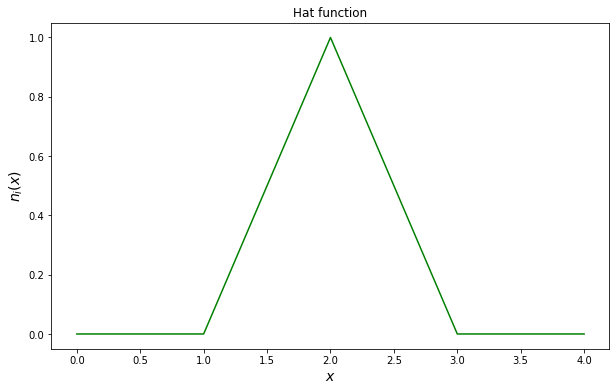

In [3]:
# Test cell 
# Si todo anda bien, debería graficarse la función sombrero

x = np.linspace(0,4,101)
interval_nodes = [1.,2.,3.]
y = np.zeros(x.shape)

for i in range(len(x)):
    y[i] = test_fun(x[i],interval_nodes)
    
plt.figure(figsize=(10, 6))

plt.xlabel("$x$",size=14)
plt.ylabel("$n_i(x)$",size=14)
plt.title("Hat function") 
plt.plot(x,y,'g-')

## La aproximación

Recordemos que estamos planteando que la solución es una combinación lineal de funciones de forma, denotado por:

$$\LARGE \tilde{y}(x) = \sum_{i=1}^{M+1}y_i n_i(x) $$

Para entender mejor la aproximación, discretizaremos el dominio $[0,1]$. Esta discretización constará de 5 elementos y 6 nodos. Recordemos que $M$ es la cantidad de elementos. Primero graficaremos cada una de las 6 funciones de forma (o de prueba), y después graficaremos la combinación lineal de estas funciones por los valores nodales $y_i$.

## Las funciones de formas

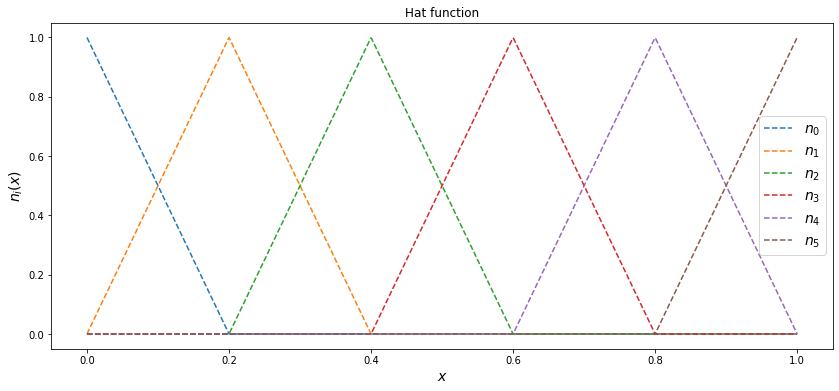

In [4]:
#Discretización
xi = np.linspace(0,1,6)
dx = xi[1]-xi[0]

#Estos vectores es para graficar la función
x = np.linspace(0,1,1000)
n = np.zeros(x.shape)

#plotting set-up
plt.figure(figsize=(14, 6))
plt.xlabel("$x$",size=14)
plt.ylabel("$n_i(x)$",size=14)
plt.title("Hat function") 

#Evaluando las funciones
contador = 0
for t in xi:
    for i in range(len(x)):
        n[i] = test_fun(x[i],[t-dx,t,t+dx])
    plt.plot(x,n,"--",alpha = 1, label='$n_{}$'.format(contador))
    contador +=1
plt.legend(fontsize=14,loc=5)
    

Claramente, en este caso, las funciones de prueba son simplemente funciones de interpolación lineal tales que el valor de la solución $y(x)$ en $x_i < x < x_{i+1}$ es una combinación lineal de los valores **"nodales"** adyacentes $y_i$ e $y_{i+1}$. En la imagen anterior, se presentan las 6 funciones de forma. Es posible observar que los elementos están espaciados por un $dx=0.2$ y definidos por los nodos $x_i$ y $x_{i+1}$. Además, si evaluamos la aproximación en el interior de un elemento, solo será necesario interpolar con los valores nodales $x_i$ y $x_{i+1}$, por ejemplo, la solución aproximada sería:

$$\Large \tilde{y}(x) = y_i n(x)_i + y_{i+1} n(x)_{i+1} \quad \quad x_i \leq x \leq x_{i+1}$$



Observar que la expresión anterior, es la interpolación lineal de los nodos adyacentes.

## Calculando la aproximación con los valores nodales

En esta sección crearemos una función que nos permita evaluar la aproximación, con los valores nodales $y_i$. Nuevamente, utilizaremos un dominio unitario entre $[0,1]$. Para ello, programe a continuación la rutina. En este caso, se realizará una implementación *naive*, solo con el propósito de ejemplificar como funciona este método.

In [5]:
def y_sol(x,yi,xi=np.linspace(0,1,6)):
    """
    Calcula la aproximación, en base a valores nodales.
    
    Parameters
    -----------
    x: float
        input
    yi: ndarray
        y nodal values
    xi: ndarray
        linear spaced nodal positions
        
    Return
    ----------
    y: float
        aproximation
    """
    dx = xi[1]-xi[0]
    y = 0.
    
    for i,t in enumerate(xi):
        y += yi[i]*test_fun(x,[t-dx,t,t+dx])
    return y

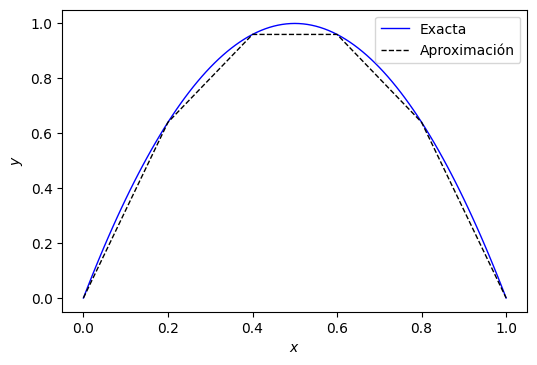

In [6]:
#Tested Cell
#Parabola entre [0,1]
x = np.linspace(0,1,101)
y = -4.*(x-0.5)**2.+1

#Aproximación de parabola con elementos.
xi = np.linspace(0,1,6)
yi = -4.*(xi-0.5)**2.+1

y_approx = np.zeros(x.shape)

for i in range(len(x)):
    y_approx[i] = y_sol(x[i],yi,xi)
    
plt.figure(dpi=100)
plt.plot(x, y,'b-',label="Exacta",linewidth=1)
plt.plot(x, y_approx,'k--',label="Aproximación",linewidth=1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
   

## La función residuo

En la sección anterior, presentamos como se puede expresar una solución a través de una combinación lineal de funciones de prueba (también llamadas de interpolación o de forma). Con el método de elementos finitos, nos interesa obtener una solución que aproxime la solución real del problema. Para ello, es crítico definit una función de **error** o **residuo**. Esta función debería ser 0 para todo $x \in \Omega$, donde $\Omega$ es el dominio de estudio.

En el Notebook anterior, de método de residuos ponderados se explica que es la función residuo. Sin embargo, aca se hará un pequeño repaso. Recordemos que nuestro problema está sujeto a un operador diferencial lineal $D$, que actúa sobre la función y(x).

$$\Large D(y(x)) = p (x)$$

Deseamos aproximar $y$ mediante una función $\tilde{y}$, que es una combinación lineal de funciones base elegidas de un conjunto linealmente independiente. En el método de elementos finitos, estas funciones de base o de forma, están definidas por las funciones de interpolación del elemento

$$\Large y \cong \tilde{y} = \sum_{i=1}^{M+1}y_i n_i(x) $$ 

Ahora, cuando se sustituye la aproximación en el operador diferencial, $D$, el resultado de las operaciones no es, en general, $p(x)$. Por tanto, existira una función residuo o error:

$$\large E(x) = R(x) = D(\tilde{y}(x))-p(x) \neq 0 $$

## Minimizar el residuo

Es importante definir una métrica para poder determinar el error de la aproximación, en este caso se utiliza la norma $l2$ para determinar que tan distinta de cero es la función. El método de residuos ponderados permite establecer diferentes formas de minimizar este residuo o hacer que tienda a cero en todo el dominio. En este caso, utilizaremos el método de Galerkin, que nos permitirá obtener la mejor solución, tomando la norma $l2$ como métrica.


### Método de Residuos Ponderados.

El método de residuos ponderados es el que nos permite minimizar el error del residuo en un sentido ponderado. Es importante mencionar que se desea encontrar los valores de $y_i$ y estos se encuentran al resolver un sistema de ecuaciones que proviene de minimizar los residuos ponderados.

$$\large \int_X R(x)W_idx = 0 \quad i=1,2,\dots,M $$ 

### Método de Galerkin
El método de Galerkin es cuando se utiliza la función de prueba como función de peso. Esto tiene propiedades muy importantes, como que el residuo será ortogonal a las funciones de base, es decir, la aproximación que se obtiene es la mejor que se podría obtener con las funciones de base que escogimos. Esto quiere decir, que la aproximación obtenida es la mejor en un sentido $l2$.


$$ \large W_i  = n_i(x)$$

Es importante reconocer las propiedades del método de Galerkin, como la ortogonalidad o el lemma de Céa's. Se invita a leer más acerca de estas propiedades. Enlace [lemma de Céa's](https://en.wikipedia.org/wiki/C%C3%A9a%27s_lemma) [2]

<img src="img/gi.png" alt="logo4" width="400"/> 

## Método de elementos finitos de Galerkin

Recordemos que la aproximación está definida como:

$$ \tilde{y} = \sum_{i=1}^{M+1}y_i n_i(x) $$ 

Por lo tanto, se puede definir el residuo como:

$$R(x;y_i) = \sum_{i=1}^{M+1}[\frac{d\tilde{y}}{dx^2}+f(x)] = \sum_{i=1}^{M+1}[\frac{d}{dx^2}[y_in_i(x)]+f(x)] $$

Es importante recordar que la función de residuo está condicionada a los valores nodales $y_i$. El siguiente paso es tuilizar el método de Galerkin, por lo que se obtiene que:

$$ \int_{x_a}^{x_b}n_j(x)R(x;y_i)dx =  \int_{x_a}^{x_b}n_j(x)\sum_{i=1}^{M+1}[\frac{d}{dx^2}[y_in_i(x)]+f(x)]dx = 0 \quad j=1,M+1$$ 
Como observamos anteriormente, solo dos funciones de pruebas son distintas de cero en el interior de un elemento ($x_j \leq x \leq x_{j+1}$). Por lo tanto, la expresión anterior se puede expresar como:

$$ \int_{x_a}^{x_b}n_j(x)R(x;y_i)dx =  \int_{x_j}^{x_{j+1}} n_j(x) [\frac{d}{dx^2}[y_j n_j(x)+y_{j+1} n_{j+1}(x)]+f(x)]dx = 0 \quad j=1,M+1  \quad \quad eq. (B) $$ 

Integrando esta ecuaciones, se llega a un sistema de ecuación de M+1 incógnitas y M+1 ecuaciones. Esto se puede escribir de la siguiente forma:

$$\Large \mathbf{Ky = F} $$

donde $\mathbf{K}$ es la matriz de "rigidez" del sistema, $\mathbf{y}$ es el vector de "desplazamientos" nodales y $\mathbf{F}$ es el vector de "fuerzas" nodales. La ecuación 5.14 es la declaración formal del método de elementos finitos Galerkin e incluye tanto la formación de elementos como los pasos de ensamblaje del sistema. Escrita en términos de integración sobre el dominio completo del problema, esta formulación muestra claramente que el dominio del problema, esta formulación muestra claramente la base matemática en el método de los residuos ponderados. Sin embargo, en la última integral es necesario integrar sobre cada elemento barra obtener las ecuaciones. Ahora procedemos a examinar la formulación de elementos separados basada en el método de Galerkin

## Formulación del elemento

<img src="img/elementos.svg" alt="logo5" width="800"/>

Si se obtiene la solución exacta de la ecuación (A), entonces esa solución satisface la ecuación en cualquier subdominio en (a, b) también. Consideremos el problema en el dominio de un elemento:

$$ \frac{d^2y}{dx^2} + f(x) = 0 \quad  x_j \leq \ x \leq x_{j+1}  \quad \quad eq(C)$$

donde $x_j$ y $x_{j+1}$ están contenidos en (a, b) y definen los nodos de un elemento finito. Las condiciones de contorno apropiadas aplicables a la ecuación (C) son

$$ y(x_j) = y_j \quad y(x_{j+1}) = y_{j+1} $$

y estos son los valores desconocidos de la solución en los puntos finales del subdominio. A continuación proponemos una solución aproximada de la forma

$$y^e(x) = y_{j}N_{j}(x)+y_{j+1}N_{j+1}(x)$$

donde el superíndice $e$ indica que la solución es para el elemento finito y las funciones de interpolación se definen ahora como

$$ N_1(x) = \frac{x_{j+1}-x}{x_{j+1}-x_{j}} \quad x_j \leq x \leq x_{j+1} $$

$$ N_2(x) = \frac{x-x_j}{x_{j+1}-x_{j}} \quad x_j \leq x \leq x_{j+1} $$

Nótese la relación entre las funciones de interpolación definidas mayúscula y las funciones de prueba con minúscula. Las funciones de **interpolación corresponden a las porciones superpuestas de las funciones de prueba aplicables en un solo elemento**. Obsérvese también que las funciones de interpolación satisfacen las condiciones

$$ N_1(x=x_j)=1 \quad N_1(x=x_{j+1})=0$$
$$ N_2(x=x_j)=0 \quad N_2(x=x_{j+1})=1$$

tal que las condiciones de contorno (nodales) del elemento, se satisfacen idénticamente. Esta propiedad de las funciones de interpolación se referencia como la identidad kronecker. La sustitución de la solución supuesta en la ecuación del residuo da como

$$ R^e(x;y_j,y_{j+1})dx = \int_{x_j}^{x_{j+1}}N_i(x)[\frac{d^2y^e}{dx^2}+f(x)]dx \quad i=1,2$$

ó

$$ \int_{x_j}^{x_{j+1}}N_i(x)\frac{d^2y^e}{dx^2}dx + \int_{x_j}^{x_{j+1}}N_i(x)f (x)dx\quad i=1,2$$

Esta ecuación se puede integrar por partes, entregando el siguiente resultado:

$$ N_i(x) \frac{dy^e}{dx} \Bigr\rvert_{x_j}^{x_{j+1}} - \int_{x_j}^{x_{j+1}}\frac{dN_i^e}{dx}\frac{dy^e}{dx}dx + \int_{x_j}^{x_{j+1}}N_i(x)f(x)dx \quad i=1,2$$

donde el superíndice se utiliza de nuevo para indicar que el residuo es para el elemento. Aplicando el criterio de residuo ponderado de Galerkin se obtiene 

$$\int_{x_j}^{x_{j+1}}\frac{dN_1^e}{dx}\frac{dy^e}{dx}dx = \int_{x_j}^{x_{j+1}}N_1(x)f(x)dx +  \frac{dy^e}{dx} \Bigr\rvert_{x_j} $$

$$\int_{x_j}^{x_{j+1}}\frac{dN_2^e}{dx}\frac{dy^e}{dx}dx =  \int_{x_j}^{x_{j+1}} N_2(x)f(x)dx - \frac{dy^e}{dx} \Bigr\rvert_{x_{j+1}} $$

Es importante notar, que las últimas dos ecuaciones utilizán una notación explicita para los límites de las derivadas. En este caso, se utiliza la propiedad de delta kronecker para satisfacer las condiciones de borde del elemento.

**La integración por parte tiene 3 beneficios**:

1. El orden de la ED se ha reducido en uno.
2. Como se demostrará empíricamente, la matriz de rigidez se ha hecho simétrica. Si es que no hubiesemos integrado por partes, una de los funciones de prueba se hubiese diferenciado dos veces y la otra función de prueba no se hubiese diferenciado.
3. La integración por partes introduce las condiciones de contorno en los nodos del elemento. El significado fisico de las condiciones de contorno de gradientes (Neumann) se vuelve aparente en las siguientes aplicaciones físicas.

Para simplificar la notación, dejaremos $j=1$

$$\int_{x_1}^{x_{2}}\frac{dN_1^e}{dx}[y_1\frac{dN_1(x)}{dx}+y_2\frac{dN_2(x)}{dx}]\frac{dy^e}{dx}dx = \int_{x_1}^{x_{2}}N_1(x)f(x)dx +  \frac{dy^e}{dx} \Bigr\rvert_{x_1} $$

$$\int_{x_1}^{x_{2}}\frac{dN_2^e}{dx}[y_1\frac{dN_1(x)}{dx}+y_2\frac{dN_2(x)}{dx}]dx =  \int_{x_1}^{x_{2}} N_2(x)f(x)dx - \frac{dy^e}{dx} \Bigr\rvert_{x_{2}} $$

### Podemos escribir esto de forma matricial:

$$\Large \begin{bmatrix}
k_{11} & k_{12} \\
k_{21} & k_{22} 
\end{bmatrix} \begin{bmatrix}
y_1  \\
y_2  
\end{bmatrix} = \begin{bmatrix}
F_1  \\
F_2  
\end{bmatrix} $$

Donde los coeficientes de la matriz de rigidez son:

$$\large k_{ij} =  \int_{x_1}^{x_2}\frac{dN_i}{dx} \frac{dN_j}{dx}dx \quad i,j = 1,2 $$

Y los términos de fuerzas, están dados por el lado derecho de la ecuación:

$$\large F_{i} =  \int_{x_1}^{x_2}N_i(x)f(x)dx +  (-1)^{i+1}\frac{dy^e}{dx} \Bigr\rvert_{x_i} \quad i = 1,2 $$

Si se sigue el procedimiento Galerkin descrito para la formulación de elementos y las ecuaciones del sistema se **ensamblan de la manera habitual del método de rigidez**, se puede lograr obtener la solución del sistema de ecuación. Es importante notar que la ecuación diferencial, se escribe como un sistema de ecuaciones:

### Ecuación diferencial => Sistema de ecuaciones

**Es importante notar que, las soluciones nodales del problema son equivalentes entre elementos. Sin embargo, los gradientes de un elemento, respecto a otro en la intersección, no son iguales**. Por ejemplo:

$$\frac{dy^{e=i}}{dx}\neq\frac{dy^{e=j}}{dx} \quad  \quad i\neq j $$

**Una forma para determinar la precisión de la aproximación es comparar la magnitud de la discontinuidad de los gradientes**

## Ejemplo 1D - Elasticidad Lineal

Consideraremos que tenemos una barra con un esfuerzo constante (para formular el elemento). Por lo tanto, la ecuación diferencial que modela esto es:

$$\frac{d\sigma_x}{dx} = \frac{d}{dx}(E\epsilon_x) = E \frac{d^2u(x)}{dx^2}=0$$

Estableceremos que el área y el módulo de elasticidad serán constantes en el elemento.

$$u(x) = u_1N_1(x) + u_2N_2(x) = u_1(1-\frac{x}{L})+u_2(\frac{x}{L})$$

En este caso, la barra tendrá un largo $L$. En este caso tenemos un volumen de interés, por lo tanto, el residuo queda como:

$$\int\int\int_V N_i(x)(E\frac{d^2u}{dx^2}dV = \int_0^LN_i(E\frac{d^2u}{dx^2})Adx = 0 \quad i=1,2 $$

donde $dV= Adx$. Integrando por partes se obtiene que:

$$ AE\int_0^L\frac{dN_i}{dx}\frac{du}{dx}=N_iAE\frac{du}{dx}\Bigr\rvert_{0}^L $$

Al evaluar la aproximación, se obtiene que:

$$ AE\int_0^L\frac{dN_1}{dx}\frac{d}{dx}(u_1N_1+u_2N_2)=-AE\frac{du}{dx}\Bigr\rvert_{0} = -AE \epsilon\Bigr\rvert_{x=0}= -A\sigma\Bigr\rvert_{0} $$

$$ AE\int_0^L\frac{dN_2}{dx}\frac{d}{dx}(u_1N_1+u_2N_2)=AE \epsilon\Bigr\rvert_{0}= -A\sigma\Bigr\rvert_{x=L} $$

Se puede observar que el lado izquierdo contiene términos relacionados a la rígidez y el lado derecho a las fuerzas nodales, ya que, $\sigma F=A$. Esta ecuaciones las podemos llevar a su formato matricial.

$$ AE\int_0^L\begin{bmatrix}
\frac{dN_1}{dx}\frac{dN_1}{dx} & \frac{dN_1}{dx}\frac{dN_2}{dx} \\
\frac{dN_2}{dx}\frac{dN_1}{dx} & \frac{dN_2}{dx}\frac{dN_2}{dx}
\end{bmatrix}dx \begin{bmatrix}
u_1  \\
u_2  
\end{bmatrix} = \begin{bmatrix}
F_1  \\
F_2  
\end{bmatrix} $$

Despues de integrar los términos, se llega a la siguiente ecuación:

$$\Large \frac{AE}{L}\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix} \begin{bmatrix}
u_1  \\
u_2  
\end{bmatrix} = \begin{bmatrix}
F_1  \\
F_2  
\end{bmatrix} $$

### Es importante observar que hemos llegado a la misma ecuación que fue presentada en la clase de Estructuras con el método de elementos finitos. [Revisar la diapositiva 13 del siguiente enlace](https://docs.google.com/presentation/d/12ItitbEK6PySfJhxCVLco8ZsYp6ydU6we98oy6lcdfc/edit?usp=sharing).

## Ejemplo 1D - Transferencia de Calor

<img src="img/heat_cond1d.svg" alt="logo6" width="800"/>

Por ahora solo nos interesa la conducción de calor en estado estacionario $\frac{\partial T}{\partial t}=0$, por lo que la ecuación de gobierno para el estado estacionario, unidimensional se obtiene como

$$ k_x \frac{d^2T}{dx^2}+Q=0 $$

donde $T$ es la temperatura de la barra, $Q$ es el calor generado, $k_x$ es el coeficiente de conducción. Es importante recordar la ley de fourier de transferencia de calor, que establece que el flujo de calor, es 

$$q_x=-k_x\frac{dT}{dx}$$

A continuación, se aplica el método de elementos finitos de Galerkin a la ecuación para obtener las ecuaciones de los elementos. Se utiliza un elemento de dos nodos con funciones de interpolación lineal y la distribución de la temperatura en un elemento se expresa como

$$ T(x) = N_1(x)T_1 + N_2(x)T_2 $$

donde T1 y T2 son las temperaturas en los nodos 1 y 2, que definen el elemento, y las funciones de interpolación $N_1$ y $N_2$ vienen dadas por la función de interpolación lineal. Como en los ejemplos anteriores, la sustitución de la solución discretizada en la ecuación diferencial gobernante da como resultado las integrales residuales:

$$\int_{x_1}^{x_2}(k_x \frac{d^2T}{dx^2}+Q)N_i(x)Adx=0 \quad i=1,2$$

donde observamos que la integración es sobre el volumen del elemento, es decir, el dominio del problema, con $dV = A dx$. Integrando el primer término por partes (por las razones ya expuestas) se obtiene

$$k_x A N_i(x)\frac{du}{dx}\Bigr\rvert_{x_1}^{x_2}-k_xA\int_{x_1}^{x_2}\frac{dN_i}{dx}\frac{dT}{dx}dx + A\int_{x_1}^{x_2}QN_i(x)dx=0 \quad i=1,2$$

Evaluando el primer término y el segundo, y evaluar la aproximación se obtiene que:

$$k_xA\int_{x_1}^{x_2}\frac{dN_1}{dx}\frac{d}{dx}[T_1N_1(x)+T_2N_2(x)]dx = A\int_{x_1}^{x_2}QN_1(x)dx -k_x A \frac{dT}{dx}\Bigr\rvert_{x_1}$$

$$k_xA\int_{x_1}^{x_2}\frac{dN_2}{dx}\frac{d}{dx}[T_1N_1(x)+T_2N_2(x)]dx = A\int_{x_1}^{x_2}QN_2(x)dx + k_x A \frac{dT}{dx}\Bigr\rvert_{x_2}$$

Estas ecuaciones se pueden escribir como

$$\Large \mathbf{K}T=F_Q+F_g $$

Donde $K$ es la matriz de conductividad ("rigidez") con términos definidos por

$$K_{ij}=k_xA\int_{x_1}^{x_2}\frac{dN_i}{dx}\frac{dN_j}{dx}dx \quad i,j=1,2 $$

El vector $\mathbf{F_Q}$, representa las "fuerzas nodales", originadas por el efecto de calor interno.

$$F_{Q1} = A\int_{x_1}^{x_2}QN_1dx $$
$$F_{Q2} = A\int_{x_1}^{x_2}QN_2dx $$

El vector $\mathbf{F_G}$ representa las condiciones de contorno de Neumann (gradientes). Si se integran los términos de la matriz de rigidez, se obtiene que:

$$\Large K=\frac{k_xA}{L}\begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix} $$

Se puede observar la similitud con la formulación del elemento general que se había deducido. El vector $\mathbf{F_Q}$ queda definido como:

$$\mathbf{F_Q} = \begin{bmatrix}
\frac{QAL}{2}  \\
\frac{QAL}{2} 
\end{bmatrix}$$

El vector $\mathbf{F_G}$ representa las condiciones de contorno de gradientes, en este caso $q_x$, que es el flujo de calor.

$$\mathbf{F_G} = k_x A \begin{bmatrix}
-\frac{dT}{dx}\Bigr\rvert_{x_1}  \\
\frac{dT}{dx}\Bigr\rvert_{x_2}
\end{bmatrix} =  A \begin{bmatrix}
q_{x_1}  \\
-q_{x_2}
\end{bmatrix}$$

Los gradientes son tales que, en los nodos internos donde se unen los elementos, los valores de los elementos adyacentes son iguales y opuestos, cancelándose matemáticamente. En los nodos externos, es decir, en los extremos del cuerpo analizado, los valores del gradiente pueden especificarse como entrada y salida de flujo de calor conocido o calcularse si la condición de contorno especificada es una temperatura. En este último caso, el cálculo del gradiente es análogo al cálculo de las fuerzas de reacción en un modelo estructural. También hay que tener en cuenta que el área es un término común en las ecuaciones anteriores y, dado que se supone que constante a lo largo de la longitud del elemento, podría ignorarse en cada término. 

## Problema Ejemplo
La varilla circular representada en la siguiente figura tiene un diámetro exterior de $60 [mm]$, una longitud de $1 [m]$, y está perfectamente aislado en su circunferencia. La mitad izquierda del cilindro es de aluminio para la cual $k_x = 200 W/m-°C$ y la mitad derecha es de cobre teniendo $k_x = 389 W/m-°C$. El extremo derecho del cilindro se mantiene a una temperatura de 80°C, mientras que el extremo izquierdo se somete a una tasa de entrada de calor de 4000 $[W/m2]$.  


1. Utilizando cuatro elementos de igual longitud, determine la distribución de temperatura en estado estacionario en el cilindro

2. Obtener la solución con 100 elementos.

<img src="img/heat_problem.svg" alt="logo7" width="600"/>


### Solución
Se presentará una implementación *naive* del problema, pero efectiva. Es importante reconocer que al momento de programar un código de elementos finitos es necesario trabajar con estructuras de datos, para asi ordenar la información de principalmente:

1. Malla (Información de nodos y elementos)
2. Tipos de elementos (tipo de elemento y orden de interpolación)
3. Condiciones de contorno (como aplicar una condición de contorno)
4. Postprocesamiento (presentar los resultados)
5. Solver del sistema de ecuaciones

En este ejemplo, se utilizará una clase para estructurar la información de los elementos.

In [7]:
#This is a very simple example of how to work with classes and to structure the data
class Element_1d():
    
    def __init__(self,nodes,mat_prop):
        #nodes = [i,j]
        #mat_prop = [kx,A,L]
        self.nodes = nodes
        self.mat_prop = mat_prop
        assert len(mat_prop) == 3,"Len. dosn't match."
        
    def k_mat(self):
        k = np.ones((2,2))
        for i in range(2):
            k[i,1-i] = -1.
        return k*self.mat_prop[0]*self.mat_prop[1]/self.mat_prop[2]

    def __str__(self):
        return "Nodes:[{}] Kx:[{}] A:[{}] L = [{}]".format(self.nodes,self.mat_prop[0],self.mat_prop[1],self.mat_prop[2])
    

In [8]:
def example_problem(n_nodes):
    #nodal discretization
    n = n_nodes
    nodes = np.linspace(0,1,n)
    dx = nodes[1]-nodes[0]

    #material properties
    A = 0.06**2*np.pi/4.
    al = [200,A,dx]
    cu = [390,A,dx] 

    #elements
    elements = []
    for i in range(1,n):
        if i <= (n-1)/2:
            elements.append(Element_1d([i-1,i],al))
        else:
            elements.append(Element_1d([i-1,i],cu))

    assert len(elements) %2 == 0, "(the num. of elements must be odd)"

    #global stiffness matrix
    k_g = np.zeros((n,n))

    for e in elements:
        k_l = e.k_mat() #calling the element stiffness matrix
        nodal_id = e.nodes
        #Local and global index loop
        for i_l, i_g in enumerate(nodal_id):
            for j_l, j_g in enumerate(nodal_id):
                k_g[i_g,j_g] += k_l[i_l,j_l]

    #b.c at the last node (Temperature or Dirichlet b.c)
    T_b = np.ones((1,1))*80.

    # heat flux or neumann b.c
    q_a = np.zeros((n-1,1))
    q_a[0] = 4000*A

    # K_aa ,K_ab, K_ba, K_bb
    k_aa = k_g[:n-1,:n-1]
    k_ab = k_g[:n-1,n-1:]

    #Solving the temperature
    T_a = np.linalg.solve(k_aa,q_a-k_ab@T_b)
    T = np.zeros((n,1))
    T[:n-1] = T_a
    T[n-1:] = T_b
    # q. sol
    q = k_g @ T
    return T,q,nodes,A

Heat-flux
 [[ 4000.]
 [    0.]
 [    0.]
 [    0.]
 [-4000.]]


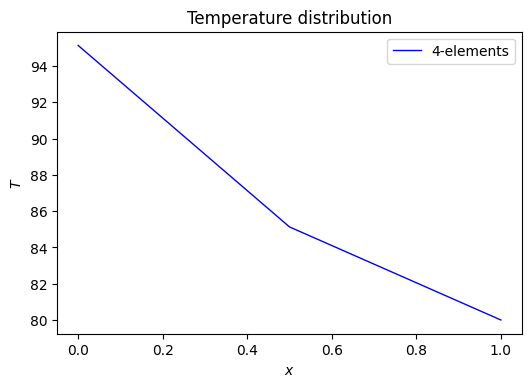

In [9]:
T, q, x,A = example_problem(5)
plt.figure(dpi=100)
plt.title("Temperature distribution")
plt.plot(x, T,'b-',label="4-elements",linewidth=1)
plt.xlabel('$x$')
plt.ylabel('$T$')
plt.legend()
print("Heat-flux\n",q/A)

Es posible apreciar, que las condiciones de contorno del problema se satisfacen de manera exacta. En este problema se encuentra la solución exacta al problema. Observar que q/A corresponde al flujo de calor y en este caso es exacto.

## Referencias

1. Hutton, D. V. (2004). Fundamental of finite element method. Mc Gaw Hill Higher Education.
2. Wu, H., Shen, D., Xia, B., Qiu, Y., Zhou, Y., & Song, Y. (2020). Parametric problems in power system analysis: recent applications of polynomial approximation based on galerkin method. Journal of Modern Power Systems and Clean Energy, 9(1), 1-12.